In [931]:
import numpy as np
import pandas as pd
from math import isnan
import roc_utils as roc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

In [932]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

## Data prep

In [933]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [1, 80],
    'highest_temperature1h': [25, 46],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [1, 200],
    'lowest_diastolic_blood_pressure1h': [1, 200],
    'lowest_systolic_blood_pressure1h': [1, 300],
    'bmi': [10, 70]
}

In [934]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [935]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [936]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [937]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [938]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [939]:
# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [940]:
class CustomImputer:
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1002]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
            output[c].fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1003]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1004]:
class CustomScaler:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.scalers = [(c, StandardScaler().fit(X[c].astype(float).values.reshape(-1,1))) for c in self.columns]
        return self

    def transform(self, X):
        output = X.copy()
        for c, s in self.scalers:
            output[c] = s.transform(output[c].astype(float).values.reshape(-1,1))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1005]:
# Lists of variable types
target = "hospitalexpireflag"

demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

## Logit trained in HIAE data

In [1658]:
# Separates X and y
X_hiae = hiae[demographic+physiological+glasgow].copy()
y_hiae = hiae[target].copy()

# Separates X and y
X_hmvsc = hmvsc[demographic+physiological+glasgow].copy()
y_hmvsc = hmvsc[target].copy()

# Create null flag column
for c in X_hiae.columns:
    X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
    X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

In [1659]:
# Get unique values for categorical features
values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Create pipeline
pipe = Pipeline([
    ("imputer", CustomImputer(normal, c_cols)),
    ("encoder", CustomLabelEncoder(values)),
    ("ohe", OneHotEncoder(c_cols)),
    ("scaler", CustomScaler(n_cols))
])

In [1660]:
# Split StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

y_true_hiae = []
y_logr_hiae = []
for train, test in skf.split(X_hiae, y_hiae):
    # Get train and test sets
    X_train, X_test = X_hiae.loc[train], X_hiae.loc[test]
    y_train, y_test = y_hiae.loc[train], y_hiae.loc[test]

    # Run pipeline
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)
    
    # Run models
    logr = LogisticRegression(penalty='l1')
    logr.fit(X_train, y_train)
    
    # Predict probs
    y_true_hiae.extend(y_test)
    y_logr_hiae.extend(logr.predict_proba(X_test))
    
# Numpy array of probs
y_true_hiae = np.array(y_true_hiae)
y_logr_hiae = np.array(y_logr_hiae)[:,1]

In [1665]:
# HMVSC validation
X_train, y_train = X_hiae.copy(), y_hiae.copy()
X_test, y_test = X_hmvsc.copy(), y_hmvsc.copy()

# Run pipeline
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# Run models
logr = LogisticRegression(penalty='l1')
logr.fit(X_train, y_train)

# Predict probs
X_rec = logr.predict_proba(X_test)
X_rec = [v ** (1/3) for v in X_rec]
y_rec = y_test.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec,
                                                    test_size=y_test.size-600, random_state=42, stratify=y_test)

# Run models
rec = LogisticRegression(class_weight={0:1.,1:1.7})
rec.fit(X_train, y_train)
    
# Predict probs
y_true_hmvsc = np.array(y_test)
y_logr_hmvsc = rec.predict_proba(X_test)[:,1]

0.8298582134754909 AUC HIAE
0.8309052059052058 AUC HMVSC


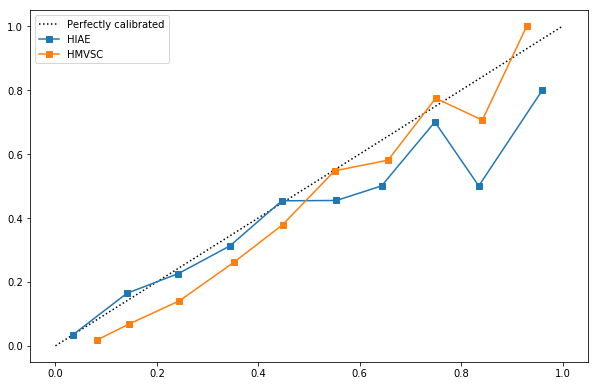

In [1666]:
# Metrics Logit

# Perfectly calibrated curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Define number of bins
n_bins = 10

# HIAE metrics
print(roc_auc_score(y_true_hiae, y_logr_hiae), "AUC HIAE")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hiae, y_logr_hiae, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HIAE")

# HMVSC metrics
print(roc_auc_score(y_true_hmvsc, y_logr_hmvsc), "AUC HMVSC")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hmvsc, y_logr_hmvsc, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HMVSC")
    
# Plot calibration
plt.legend()
plt.show()

### XGBoost trained in HIAE data

In [1669]:
# Separates X and y
X_hiae = hiae[demographic+physiological+glasgow].copy()
y_hiae = hiae[target].copy()

# Separates X and y
X_hmvsc = hmvsc[demographic+physiological+glasgow].copy()
y_hmvsc = hmvsc[target].copy()

In [1670]:
# Get unique values for categorical features
values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Create pipeline
pipe = Pipeline([
    ("lenc", CustomLabelEncoder(values))
])

In [1671]:
# Split StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

y_true_hiae = []
y_xbst_hiae = []
for train, test in skf.split(X_hiae, y_hiae):
    # Get train and test sets
    X_train, X_test = X_hiae.loc[train], X_hiae.loc[test]
    y_train, y_test = y_hiae.loc[train], y_hiae.loc[test]
    
    # Run pipeline
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)
    
    # Run models
    xbst = XGBClassifier(n_estimators=100, max_depth=2)
    xbst.fit(X_train, y_train)
    
    # Predict probs
    y_true_hiae.extend(y_test)
    y_xbst_hiae.extend(xbst.predict_proba(X_test)[:,1])
    
# Numpy array of probs
y_xbst_hiae = np.array(y_xbst_hiae)

In [1674]:
# HMVSC validation
X_train, y_train = X_hiae.copy(), y_hiae.copy()
X_test, y_test = X_hmvsc.copy(), y_hmvsc.copy()

# Run pipeline
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# Run models
xbst.fit(X_train, y_train)

# Predict probs
X_rec = xbst.predict_proba(X_test)
X_rec = [v ** (1/3) for v in X_rec]
y_rec = y_test.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec,
                                                    test_size=y_test.size-600, random_state=42, stratify=y_test)

# Run models
rec = LogisticRegression(class_weight={0:1.,1:1.7})
rec.fit(X_train, y_train)
    
# Predict probs
y_true_hmvsc = np.array(y_test)
y_xbst_hmvsc = rec.predict_proba(X_test)[:,1]

0.8352754372542791 AUC HIAE
0.8335158107885381 AUC HMVSC


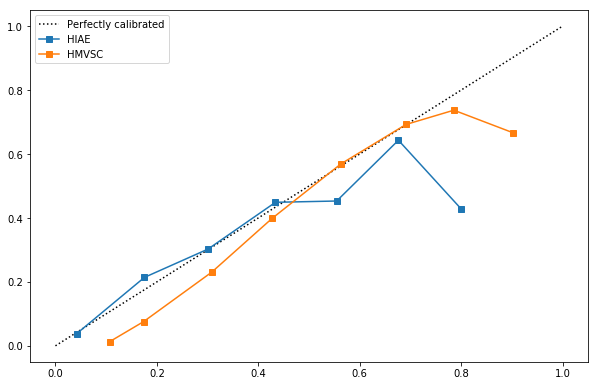

In [1675]:
# Metrics XGBoost

# Perfectly calibrated curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Define number of bins
n_bins = 8

# HIAE metrics
print(roc_auc_score(y_true_hiae, y_xbst_hiae), "AUC HIAE")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hiae, y_xbst_hiae, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HIAE")


# HMVSC metrics
print(roc_auc_score(y_true_hmvsc, y_xbst_hmvsc), "AUC HMVSC")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hmvsc, y_xbst_hmvsc, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HMVSC")


# Plot calibration
plt.legend()
plt.show()